<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания предлагающая сервисы агрегатора такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Для этого необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

RMSE - квадратный корень из среднеквадратической ошибки (Root Mean Square Error). Формула RMSE:

$$
\large{RMSE = \sqrt{\frac{\underset{i=1}{\overset{n}{\Sigma}}(d_{i}-f_{i})^2}{n}}}
$$

Для решения поставленной задачи нам необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import catboost as cb
import lightgbm as lgb
from tqdm import notebook
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 12345

In [3]:
data = pd.read_csv('C:\\Users\\mikha\\Desktop\\Data scince\\Projects\\Data\\Данные Проект Временные ряды.csv', 
                       index_col=[0], parse_dates=[0])

#отсортируем по дате    
data.sort_index(inplace=True)

print(data.info())
print()
data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None



,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


У нас имеются данные с марта по август 2018-го года с частотой в 10 минут.

Ресемплируем данные по одному часу. Заказы просуммируем.

In [4]:
data = data.resample('1H').sum()

## Анализ

Для более детального анализа, возьмем небольшой промежуток в 1 неделю.

Text(0.5, 1.0, 'Распределение заказов')

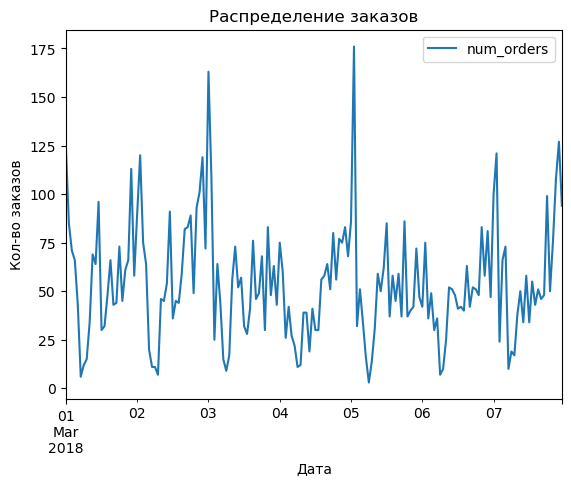

In [5]:
data['2018-03-01':'2018-03-07'].plot()
plt.xlabel("Дата")
plt.ylabel("Кол-во заказов")
plt.title(label = 'Распределение заказов')

По графику первой недели видно, что пиковая нагрузка происходит под конец дня и далее она опускается до минимума под утро.

Декомпозируем наши данные. Изучим сезонность и тренд. 

Для визуализации сезонности возьмем недельный интервал. Для визуализации тренда - весь датасет.

In [6]:
decomposed = seasonal_decompose(data) 

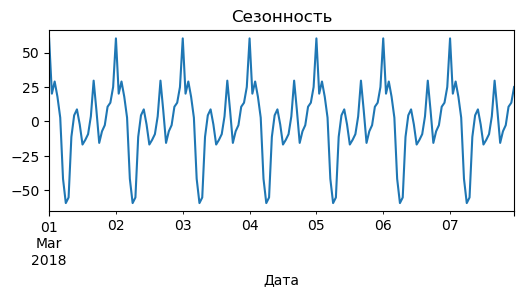

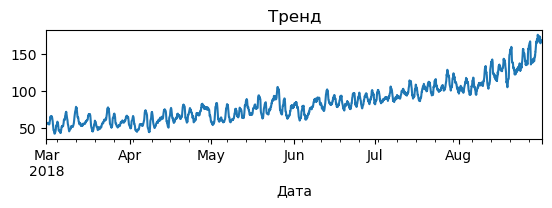

In [7]:
plt.figure(figsize=(6,8))
plt.subplot(311)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel("Дата")
plt.show()


plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel("Дата")
plt.show()

Сезонность соответствует описанным ранее наблюдениям. А вот тренд растет. Тяжело сказать с чем это связано. Интуитивно, можно было бы предположить, что тренд должен расти в мае и начать снижение в концу лета, однако к концу августа тренд самый высокий. Видимо на это могут быть другие причины (увеличение популярности сервиса).

Проверим константную модель. За прогноз возьмем предыдущие значения ряда.

In [8]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

print("Среднее кол-во заказов в час:", test['num_orders'].mean())

pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print("RMSE константной модели:", mean_squared_error(test, pred_previous)**0.5)

Среднее кол-во заказов в час: 139.55656108597285
RMSE константной модели: 58.856486242815066


Создадим функцию для создания признаков. Добавим столбы c днем, днем недели и часом, столбец с «Отстающими значениями», «Скользящее среднее» и стобец с разницей целевого признака и «Скользящим средним».

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = pd.DataFrame(columns=data.columns, index=data.index, data=data.values)
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    new_data['hour'] = new_data.index.hour
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)
          
    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

Определим какие параметры "Лагов" и "Скользящего среднего" подходят лучше всего.

Начнем с "Остающих значений". Воспользуемся "Графиком Функции автокорреляции" (`plot_acf`) для определения наилучшего "сдвига".

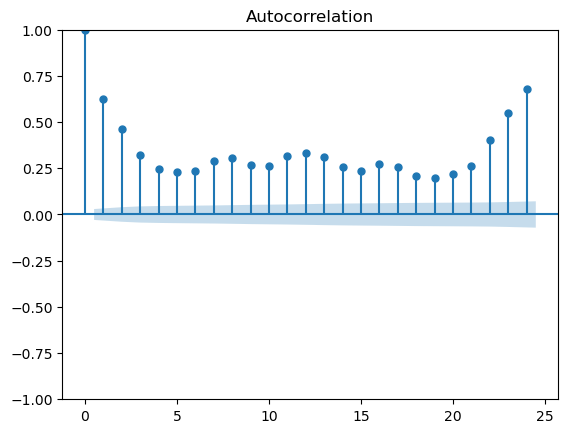

In [10]:
plot_acf(data['num_orders'], lags=24)
plt.show()

Видно, что самая высокая корреляция с ближайшим часом (+/- 1 час) и ровно через сутки (24 часа). Зависимость объяснима, как ежедневной сезонностью заказов (каждые 24 часа заказы похожи), так и зивисимостью двух "соседних" часов (ближе всего к кол-ву заказов в час n - кол-во заказов в час n+/-1).

24 часа имеют немного большую корреляцию, но создают много доп. столбцов. Будем использовать сдвиг в 1 час. 

Для скользящего среднего будем использовать 24 часа. Этим признаком мы как-бы "сгладим" прыдущие сутки, что в дальнейшем поможет учесть постепенно повышающееся кол-во заказов.

Подготовим данные для обучения и тестирования моделей.

In [11]:
new_data = make_features(data, 1, 24)
new_data = new_data.dropna()
features = new_data.drop('num_orders', axis=1)
target = new_data['num_orders']
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            shuffle=False, test_size=0.1)

## Обучение

Для этого проекта будем использовать 3 модели: Линейнеую регрессию и Catboost и LGBM.

Для подбора параметров для моделей будем использовать `TimeSeriesSplit`. В нашей задаче в тестовой выборке 10 процентов от общих данных. Посчитаем, на сколько частей необходимо разделить трейн для дальнейшего корректного прогноза тестовой выборки.

In [12]:
len(target_train)/len(target_test)

8.981818181818182

Примерно на 9 частей.

In [13]:
tss = TimeSeriesSplit (n_splits = 9)

**Обучение модели линейной регрессии.**

In [14]:
lin_model = LinearRegression()

lin_res = abs(cross_val_score(lin_model, features_train, target_train, cv=tss, scoring ='neg_root_mean_squared_error').mean())


print("RMSE модели линейной регрессии:",lin_res)

RMSE модели линейной регрессии: 31.28342868893296


Результат немногим лучше константной модели.

**Обучение модели Catboost.**

Определим категориальные столбцы для Catboost.

In [15]:
category=['day', 'dayofweek', 'hour']

In [16]:
best_cat_result = 20000
best_cat_lr = 0
best_cat_deapth = 0
best_cat_iterations = 0
best_cat_model = None

for lr in notebook.tqdm([0.1, 0.3, 0.5]):
    for dp in [1, 5, 10]:
        for itr in [25, 50, 100]:
            cat_model = cb.CatBoostRegressor(random_state=RANDOM_STATE, cat_features=category, loss_function='RMSE', 
                                             iterations=itr, depth=dp, learning_rate=lr, verbose=0)
            cat_result = abs(cross_val_score(cat_model, features_train, target_train, cv=tss, 
                                             scoring ='neg_root_mean_squared_error').mean())
            if cat_result < best_cat_result:
                best_cat_model = cat_model
                best_cat_result = cat_result
                best_cat_deapth = dp
                best_cat_iterations = itr
                best_cat_lr = lr

            
print ("RMSE наилучшей модели:", best_cat_result)   
print ("Максимальная глубина:", best_cat_deapth)
print ("Количество итераций:", best_cat_iterations) 
print ("Скорость обучения:", best_cat_lr)

  0%|          | 0/3 [00:00<?, ?it/s]

RMSE наилучшей модели: 25.520729837713745
Максимальная глубина: 5
Количество итераций: 100
Скорость обучения: 0.1


Catboost показывает хорошие результаты.

**Обучение модели LGBM.**

Определим категориальные столбцы для LGBM.

In [17]:
features_train.columns

Index(['day', 'dayofweek', 'hour', 'lag_1', 'rolling_mean'], dtype='object')

In [18]:
category_lgbm = [0,1,2]

In [19]:
best_lgb_result = 20000
best_lgb_lr = 0
best_lgb_deapth = 0
best_lgb_iterations = 0
best_lgb_model = None

for lr in [0.1, 0.3, 0.5]:
    for dp in [1, 5, 10]:
        for itr in [25, 50, 100]:
            lgb_model = lgb.LGBMRegressor(random_state=RANDOM_STATE, objective="rmse", \
                                          categorical_feature=category_lgbm, num_iterations=itr, max_depth=dp, \
                                          learning_rate=lr)
            lgb_result = abs(cross_val_score(lgb_model, features_train, target_train, cv=tss, 
                                             scoring ='neg_root_mean_squared_error').mean())
            if lgb_result < best_lgb_result:
                best_lgb_model = lgb_model
                best_lgb_result = lgb_result
                best_lgb_deapth = dp
                best_lgb_iterations = itr
                best_lgb_lr = lr

            
print ("RMSE наилучшей модели:", best_lgb_result)   
print ("Максимальная глубина:", best_lgb_deapth)
print ("Количество итераций:", best_lgb_iterations) 
print ("Скорость обучения:", best_lgb_lr)

RMSE наилучшей модели: 25.22856971386833
Максимальная глубина: 10
Количество итераций: 50
Скорость обучения: 0.1


RMSE у LGBM самый лучший и работает на порядок быстрее. Будем использовать его для финального тестирования.

## Тестирование

In [20]:
best_lgb_model.fit(features_train, target_train)
test_lgb_model_predict = best_lgb_model.predict(features_test)
test_lgb_model_result = mean_squared_error(target_test, test_lgb_model_predict)**0.5

print ("RMSE LGBM на тестовой выборке:", test_lgb_model_result)

RMSE LGBM на тестовой выборке: 44.22135462932875


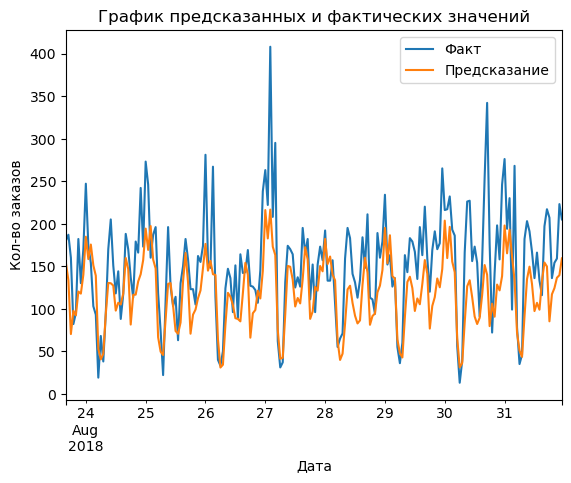

In [21]:
final_res = pd.DataFrame(columns=['Факт', 'Предсказание'], index=target_test.index)
final_res['Факт'] = target_test.values
final_res['Предсказание'] = test_lgb_model_predict
final_res[-200:].plot()
plt.xlabel("Дата")
plt.ylabel("Кол-во заказов")
plt.title(label = 'График предсказанных и фактических значений')
plt.show()

**Вывод**

Модели LGBM на тесте удалось показать хороший результат RMSE - 44.2. Как видно по графику модель справляется с задачей достаточно хорошо, однако в особо пиковых нагрузках, "не успевает" за реальным спросом, а вот в "провалах", наоборот, модель очень хорошо себя показывает.

*Проект окончен.*

***Спасибо за уделенное работе время!***